# Estimating sales price of a house/apartment

The data for this exercise is information on about 50000 house (or apartment) sales, for which there are several (90) pieces of information (i.e. features) along with the sales price. The data is neither representative for Denmark, nor very recent and accurate, **yet it presents a great case for applying Machine Learning**.

The data has got several missing/9999 values and other flaws to consider, before applying any further data analysis. Thus, the exercise consists of two parts:<br>
1) **Inspecting and Cleaning the data**<br>
2) **Make a regression algorithm with the "pricepaid" as target**<br>


### Features:
The data has many features / input variables (X), the most important of which are:
* postalcode : variable( 4  ) , # Selfexplanatory!
* salesdate  : variable( 12 ) , # The actual sales price
* sizein     : variable( 32 ) , # In-door area, whole house/apartment
* sizeout    : variable( 34 ) , # Out-door area, i.e. garden etc.
* condition  : variable( 52 ) , # Condition of house/apart, where 1/6 is best/worst (often missing!)
* pricepaid  : variable( 89 ) , # The target (Y), i.e. the price paid for the house/apartment

Make sure that you think about (and discuss) which of the many features should be included.

### Questions:
Try to see, if you can answer the following questions:<br>
1) What loss function do you use?<br>
2) How small a percentage error can you get?<br>
3) Is it the same for all conditions and postal codes?<br>
4) How do you deal with the missing information?<br>

***

* Author: Troels C. Petersen (NBI) & Christian Michelsen (NBI)
* Email:  petersen@nbi.dk
* Date:   5th of May 2021 (latest version)

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
import numpy as np
import pandas

import math
from array import array

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# For better looking text on figures
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')

### Class definitions

We define a class for the columns that we are interested in. It holds the index at which it appears, the value for each entry (that the file reading loop assigns), a boolean value that tells us if the value is properly stored in the list, and finally a value that we set in the loop further down which tells us if the value is useable (see below example).

In [2]:
class variable:
    def __init__( self , column_index ) :
        self.column_index = column_index
        self.value = -1
        self.isValid = False
        self.isGood = False # You set this to True in the loop if the value makes sense
                            # Note that this does not mean that the value is actually good
                            # Example: If condition is -1, the value is valid but bad

In [3]:
# Whether to save all the plots to disk
SavePlots = False

# Whether to print extra information, debugging goodies, etc.
Verbose = True

# Here you add all the columns from the dataset that you are actually
# interested in.
variable_list = {
# name         : variable( column_index )
  "postalcode" : variable( 4  ) ,
  "salesprice" : variable( 11 ) , # The estimated price? Often 0
  "salesdate"  : variable( 12 ) , # The actual sales price
  "address"    : variable( 25 ) ,
  "sizein"     : variable( 32 ) , # in-door area, whole apartment
  "sizeout"    : variable( 34 ) , # garden, whole lot
  "condition"  : variable( 52 ) , # 1-6
  "pricepaid"  : variable( 89 )
}

###  Variable declarations

We make a counter for each column that stores validness and one that stores validness+goodness. We will use them to consider the quality of whole columns and thereby their usefulness in later analysis.

In [4]:
valid_list = { name: 0 for name, var in variable_list.items() }
valid_and_good_list = { name: 0 for name, var in variable_list.items() }

# All the rows that made it past the essential checks are saved here
values = { name: [] for name , var in variable_list.items() }

# A counter for each row (even if all the values are invalid).
num_rows = 0

# A counter for all the rows where all the essential columns
# are all good.
num_essential_rows = 0

# Screen resolution (used to convert inches to pixels for the figures)
my_dpi = 96

###  User-defined helper functions

In [5]:
# "is Not a Number" that works on strings
def isNaN(num) :
    return num != num

# If the entry is valid
def isValid( num ) :
    return not isNaN( num ) and num != "NULL"

# We should always CHECK FIRST if we can convert a value from string
# to a number! Integer conversion has another funny pithole:
# If we try to convert a string "10.0" to integer, python actually
# throws an exception. So we should check first to make sure!
def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

# Same deal: Check first before converting!
def isFloat(s):
    try: 
        float(s)
        return True
    except ValueError:
        return False

# Square function
def sqr(a) : return a*a

# Stat.box in figures
def DrawEntryBox( el_list , x_min , x_max , x = 0.85 , y = 0.90 ) :
    mean , rms = MeanRMS( el_list , x_min , x_max )
    
    textstr = r'\begin{eqnarray*}\mathrm{Entries}& %d\\\mu& %.3f\\\sigma& %.3f\end{eqnarray*}'%(len(el_list),mean,rms)
    
    # these are matplotlib.patch.Patch properties
    props = dict(facecolor='white',edgecolor='black', pad=20.0)
    
    # place a text box in upper left in axes coords
    plt.gca().text(x,y, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

# Mean and RMS of a list of values ( support ranges )
def MeanRMS( inlist , x_min = None , x_max = None ) :
    if x_min is None or x_max is None :
        mean = np.mean(inlist)
        rms = math.sqrt(np.var(inlist))
    else :
        inlist_array = np.array(inlist)
        inlist_ranged = inlist_array[(inlist_array > x_min) & (inlist_array <x_max)]
        mean = np.mean(inlist_ranged)
        rms = math.sqrt(np.var(inlist_ranged))
    
    return ( mean , rms )

# Mean and RMS of a list of values ( support ranges ) and a list of values used when drawing a Gaussian from the mean and sigma
def MeanRMSXlist( inlist , x_min = None , x_max = None ) :
    if x_min is None or x_max is None :
        mean = np.mean(inlist)
        rms = math.sqrt(np.var(inlist))
        x_fit = np.linspace(min(inlist), max(inlist),100)
    else :
        inlist_array = np.array(inlist)
        inlist_ranged = inlist_array[(inlist_array > x_min) & (inlist_array <x_max)]
        mean = np.mean(inlist_ranged)
        rms = math.sqrt(np.var(inlist_ranged))
        x_fit = np.linspace(min(inlist_ranged), max(inlist_ranged),100)
    
    return ( mean , rms , x_fit )

# Plot linear fit
def PlotLinearFit( x , y , color = "blue" , linewidth = 2.0 ) :    
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'b-', color=color , linewidth=linewidth)

# Plot linear fit, forced through the origin
def PlotLinearFitThroughOrigin( x , y ) :
    x_ = np.array(x)
    x_ = x_[:,np.newaxis]
    a, _, _, _ = np.linalg.lstsq(x_, y)
    plt.plot(x_, a*x_, 'r-', linewidth=2.0)

***

# Main analysis

## Reading in the data:

This part includes checking the data, and getting basic counting statistics.

In [6]:
# Open file
f = open("HousingPrices.csv", "r")

# Read, print (if verbose) and ignore header lines
header1 = f.readline()
header2 = header1.strip()
header3 = header2.split(";")
if ( Verbose ) :
    for i in range( len(header3) ) :
        print(i, header3[i] )

# Loop over lines and extract variables of interest
for line in f :
    # Cut away spaces at the ends
    line = line.strip()
    
    # Split the row with ";" as delimeter
    columns = line.split(";")
    
    # Read another row
    num_rows += 1
    
    # Every essential variable increments this number.
    # If the number is exactly X, all essential variables
    # passed.
    essentials_passed = 0
    
    # Loop over every variable in our list of variables
    for name, var in variable_list.items() :
        # Reset previous value
        var.value = -1
        var.isValid = False
        var.isGood = False
        
        # Retrieve the column value from the current row,
        # and remove any spaces that might be at the beginning
        # or end of it
        val = columns[var.column_index].strip()
        
        # If the value is valid move on to test goodness. If
        # it is not valid, do not bother checking further.
        if ( isValid(val) ) :
            var.isValid = True
            
            # If it is the postal code column, we should first check
            # if the entry is an integer before we check the value itself.
            # If the value is not an integer, the typecast will throw an
            # exception that kills our code!
            if ( name is "postalcode" and isInt(val) ) :
                # All good! We save the value as an integer
                var.value = int(val)
                
                # We check if the value is in the postal code range
                # which is probably between 0 and 10000 to a good
                # first approximation.
                var.isGood = ( var.value > 0 and var.value < 10000 )
                
                # If is good, increment essentials passed
                essentials_passed += var.isGood
            
            # Sales price is rounded down to 1/100 of our currency,
            # so it is a float.
            if ( name is "salesprice" and isFloat(val) ) :
                # All good! We save the value as a float
                var.value = float(val)
                
                # Of course the value should be positive.
                # But can we set an upper limit now, or should
                # we reserve that for later? We could set some
                # absurd upper limit like 100 billion. Any number
                # above this limit is quite likely corrupt.
                var.isGood = ( var.value > 0 and var.value < 1e11 )
            
            # The sales date is a string on the form YYYY-MM-DD.
            # Of course we should check to make sure!
            if ( name is "salesdate" ) :
                var.value = val
                # We are lazy, so we will just make sure that the day
                # is not in the future.
                month = int(var.value[5:7])
                year = int(var.value[0:4])
                months_since = 12*(2016-year)+(8-month)
                var.isGood = ( months_since >= 0 )
                # Now, we should also check that DD, MM, and YYYY are
                # valid: Is 1<=MM<=12, does DD exist in month MM, etc.
                # But let us just assume that for now.
                
                essentials_passed += var.isGood
            
            # The adress is just a string. It must not be empty!
            if ( name is "address" ) :
                var.value = val
                var.isGood = bool(var.value)
                essentials_passed += var.isGood
            
            # The in-door size can be 0, if only the whole lot/garden has
            # been considered. BUT we should check that sizein+sizeout is
            # not zero.
            # For this example we require that the indoor area has been
            # stored!
            if ( name is "sizein" and isInt(val) ) :
                var.value = int(val)
                var.isGood = ( var.value > 0 )
                essentials_passed += var.isGood
            
            # The out-door size can be 0, if it is e.g. an apartment
            if ( name is "sizeout" and isInt(val) ) :
                var.value = int(val)
                var.isGood = ( var.value >= 0 )
            
            if ( name is "condition" and isInt(val) ) :
                var.value = int(val)
                var.isGood = ( var.value >= 1 and var.value <= 6 )
                essentials_passed += var.isGood
            
            # This seems to always be an integer, but
            # we shouldn't restrain ourselves yet.
            if ( name is "pricepaid" and isFloat(val) ) :
                var.value = float(val)
                var.isGood = ( var.value > 0 and var.value < 1e11 )
                essentials_passed += var.isGood
        
        # Statistics on quality of our data
        valid_list[name] += var.isValid
        valid_and_good_list[name] += var.isValid and var.isGood
    
    # We have retrieved the values we are interested in.
    # Let's check if we have all the essentials.
    if ( essentials_passed == 6 ) :
        num_essential_rows += 1
    # Else move on to the next row!
    else :
        continue
   
    # We have made it. Save this row!
    for name, var in variable_list.items() :
        values[name].append( var.value )
   
   # As as test: Show entries for Oesterbro:
   # if ( Verbose and variable_list["postalcode"].value == 2100 ) :
   #     print("  Sales Price: %10.1f    Sales Date: %10s      Size: %6.1f / %6.1f    Condition: %2d    Price Paid: %10.1f    Address: %20s, %4d"%( variable_list["salesprice"].value , variable_list["salesdate"].value , variable_list["sizein"].value , variable_list["sizeout"].value , variable_list["condition"].value , variable_list["pricepaid"].value , variable_list["address"].value , variable_list["postalcode"].value ))

# Output statistics. Automatically filled.
print("\n\n  ------------------------------------------------------------------------")
print("      Total entries:  %7d"%(num_rows))
print("  Essentials passed:  %7d"%(num_essential_rows))
print("  ------------------------------------------------------------------------")
print("            Variable    # Valid         # Valid and good   # Valid but bad")
for name, var in variable_list.items():
    print("  %16s :  %7d  (%3d%%) %7d  (%3d%%)   %7s  (%3d%%)"%( name , valid_list[name] , float(valid_list[name])/float(num_rows)*100.0 , valid_and_good_list[name] , float(valid_and_good_list[name])/float(num_rows)*100.0 , str(valid_list[name]-valid_and_good_list[name]) if (valid_list[name]-valid_and_good_list[name])>0 else "-" , float(valid_list[name]-valid_and_good_list[name])/float(num_rows)*100.0 ))
print("  ------------------------------------------------------------------------")


0 ﻿MI_OBJ_OIS_PROPERTY_ID
1 MI_OBJ_OIS_PROPERTY_NUMBER
2 MI_OBJ_OIS_MOTHER_ID
3 MI_OBJ_OIS_MUNICIPALITY_NUMBER
4 MI_OBJ_OIS_POSTAL_CODE
5 MI_OBJ_OIS_RENTED_PLOT
6 MI_OBJ_OIS_OWNERSHIP_CODE_PROPERTY
7 MI_OBJ_OIS_OWNERSHIP_CODE_UNIT
8 MI_OBJ_OIS_PROPERTY_APPLICATION_CODE_UNIT
9 MI_OBJ_OIS_PROPERTY_APPLICATION_CODE_BUILDING
10 MI_OBJ_OIS_PROPERTY_USE_CODE
11 MI_OBJ_OIS_SALES_PRICE
12 MI_OBJ_OIS_DATE_OF_SALES_PRICE
13 MI_OBJ_OIS_PREVIOUS_SALES_PRICE_FIRST
14 MI_OBJ_OIS_DATE_OF_PREVIOUS_SALES_PRICE_FIRST
15 MI_OBJ_OIS_PREVIOUS_SALES_PRICE_SECOND
16 MI_OBJ_OIS_DATE_OF_PREVIOUS_SALES_PRICE_SECOND
17 MI_OBJ_OIS_PREVIOUS_SALES_PRICE_THIRD
18 MI_OBJ_OIS_DATE_OF_PREVIOUS_SALES_PRICE_THIRD
19 MI_OBJ_OIS_PREVIOUS_SALES_PRICE_FOURTH
20 MI_OBJ_OIS_DATE_OF_PREVIOUS_SALES_PRICE_FOURTH
21 MI_OBJ_OIS_TAXATION_VALUE
22 MI_OBJ_OIS_TAXATION_VALUE_PLOT
23 MI_OBJ_OIS_TAXATION_VALUE_FARMHOUSE
24 MI_OBJ_OIS_DATE_OF_TAXATION_VALUE
25 MI_OBJ_OIS_PROPERTY_ADDRESS
26 MI_OBJ_OIS_HOUSE_NUMBER
27 MI_OBJ_OIS_HOUSE_LETT

***

# Data analysis

Having read in the data, we now proceed to inspect it to see, what it contains, and if this makes sense. Producing an array of plots involving the key features/variables is usually a **very** good idea!

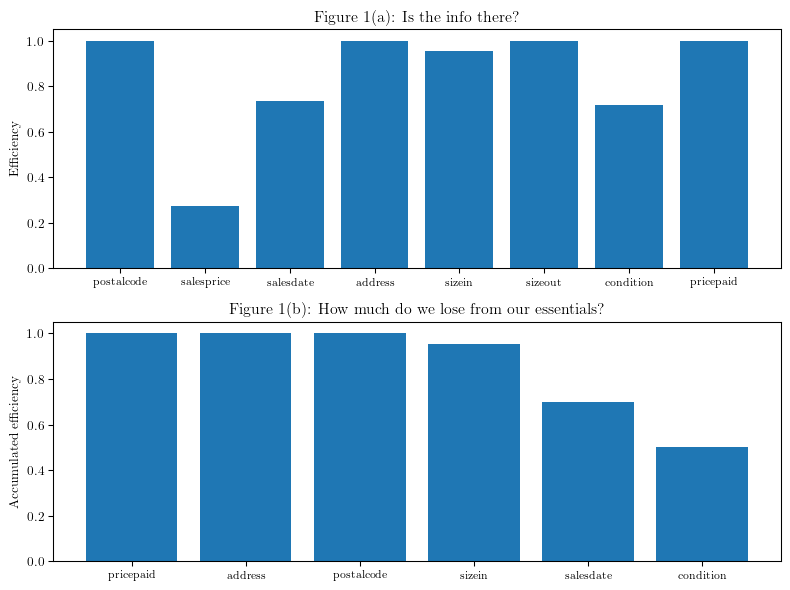

In [7]:
# Let us make some easier variables (in order of importance)
pricepaid = values["pricepaid"]
address = values["address"]
postalcode = values["postalcode"]
sizein = values["sizein"]
salesdate = values["salesdate"]
condition = values["condition"]
salesprice = values["salesprice"]
sizeout = values["sizeout"]

# --------------------------------------------------------- #
#  Figure 1(a): Is the info there?
#  Figure 1(b): How much do we lose from our essentials?
# --------------------------------------------------------- #
# Calculate some values
names = [ name for name , var in variable_list.items() ]
effs = [ float(valid_and_good_list[name])/float(num_rows) for name , var in variable_list.items() ]
names_essentials = ( "pricepaid" , "address" , "postalcode" , "sizein" , "salesdate" , "condition" )
vars_in_order_of_importance = ( float(valid_and_good_list["pricepaid"])/float(num_rows) , float(valid_and_good_list["address"])/float(num_rows) , float(valid_and_good_list["postalcode"])/float(num_rows) , float(valid_and_good_list["sizein"])/float(num_rows) , float(valid_and_good_list["salesdate"])/float(num_rows) , float(valid_and_good_list["condition"])/float(num_rows) )
effs_accumulated = [ np.prod(vars_in_order_of_importance[1:i]) for i in range(1,1+len(vars_in_order_of_importance)) ]

# Set up figure
plt.figure(figsize=(800/my_dpi, 600/my_dpi), dpi=my_dpi)
plt.gcf().canvas.set_window_title('Figures 1(a) and 1(b)')

plt.subplot( 2 , 1 , 1 )
plt.bar(range(len(names)), effs, align='center')
plt.xticks(range(len(names)), names, size='small')
plt.ylabel('Efficiency')
plt.title('Figure 1(a): Is the info there?')

plt.subplot( 2 , 1 , 2 )
plt.bar(range(len(names_essentials)), effs_accumulated, align='center')
plt.xticks(range(len(names_essentials)), names_essentials, size='small')
plt.ylabel('Accumulated efficiency')
plt.title('Figure 1(b): How much do we lose from our essentials?')

# Draw
plt.tight_layout()
if (SavePlots) : plt.savefig("Figures1ab.pdf") # Save plot (format follow extension name)
plt.draw()